In [297]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import random
import itertools
import matplotlib.patches as mpatches
from statistics import mean
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import modularity
from networkx.algorithms.community import naive_greedy_modularity_communities


### Useful functions

In [298]:
#Useful functions

    #loading data for Graph generation
def load_data(filename):
    input_lines = []
    raw_lines = open(filename, 'r').read().splitlines()
    num_nodes = 0
    nodes = {}
    for line in raw_lines:
        line_content = line.split()
        from_id = int(line_content[0])
        to_id = int(line_content[1])
        if from_id not in nodes:
            nodes[from_id] = num_nodes
            num_nodes += 1
        if to_id not in nodes:
            nodes[to_id] = num_nodes
            num_nodes += 1
        input_lines.append([nodes[from_id], nodes[to_id]])
    return input_lines, num_nodes

#Display statistic of nodes degree
def show_degree_distribution(G,name):
    nodes_degrees_x = []
    nodes_degrees_y = []
    G2 = G.copy()
    edges_counter = 1
    generation = 0
    while True:
        iter_counter = 0
        for e in G2.nodes:
            if len(list(G2.neighbors(e))) == edges_counter:
                iter_counter += 1
        if iter_counter == 0 : break
        nodes_degrees_x.append(generation)
        nodes_degrees_y.append(iter_counter)
        generation +=1
        edges_counter += 1

    fig = plt.figure(1, figsize=(20, 20))
    ax = fig.add_subplot(211)
    ax.scatter(nodes_degrees_x,nodes_degrees_y,s=50,facecolor='none',edgecolors='r')
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.ylabel("No. node",fontsize=18)
    plt.xlabel("Degree",fontsize=18)
    red_patch = mpatches.Patch(color="red", label=name)
    ax.legend(handles=[red_patch],prop={'size': 20})
    plt.show()

def filtered_graph(G):
    node_list = []
    for e in G2.nodes:
        neigh_list = list(G.neighbors(e))
        if  len(neigh_list) == 1:
            neigh = neigh_list[0]
            node_list.append([e,neigh])
    if len(node_list) != 0:
        for n in node_list:
            if(G.has_edge(n[0],n[1])):
                G.remove_edge(n[0],n[1])
            # G.remove_node(n[0])
        return filtered_graph(G)
    return G

def get_subgraphs_cluster(G):
    communities = greedy_modularity_communities(G)
    print("Number of communities with best modularity: "+str(len(communities)))
    communities_subgraphs = []
    for c in communities:
        communities_subgraphs.append(G.subgraph(c))
    return communities_subgraphs

def compute_distance_v_Ci(v,cluster,G_biconnected_core,sigma):
    links_Ci_Ci = cluster.number_of_edges() #number of intra-cluster links
    deg_Ci = sum(dict(G_biconnected_core.degree(cluster.nodes())).values())
    deg_V = G_biconnected_core.degree(v)
    links_v_Ci = cluster.degree(v)
    distance = -1*((2*links_v_Ci) /(deg_V*deg_Ci)) + links_Ci_Ci/(deg_Ci**2) + (sigma/deg_V) - (sigma/deg_Ci)
    return distance

def compute_graclus_center(clusters_list,G_biconnected_core):
    seed_dict = {}
    for (idx,cluster) in enumerate(clusters_list):
        distance_array = {}
        for n in cluster.nodes:
            distance = compute_distance_v_Ci(n,cluster,G_biconnected_core,1)
            distance_array[n] = distance
        seed_dict["C"+str(idx)] = min([(value,key) for key,value in distance_array.items()])[1]
    return seed_dict
    
def compute_seed_by_spred_hubs(G,k):
    seed_list  = []
    while len(seed_list) < k:
        filtered_visited = [n for n in G.nodes() if G.nodes[n]["visited"] == False]
        filtered_visited_graph = G.subgraph(filtered_visited)
        max_degree = max([e[1] for e in filtered_visited_graph.degree])
        filtered_nodes = [n for n in G.nodes() if G.degree(n) == max_degree] 
        for n in filtered_nodes:
            seed_list.append(n)
            G.nodes[n]["visited"] = True
            for neig in G.neighbors(n):
                G.nodes[neig]["visited"] = True
    return 


## Loading and decsription data Phase

In [299]:
#Load dataset into networkx
dataset_name="HepPh"
path ="..\datasets\\facebook\\0.edges"
# path ="..\datasets\\myspace\\soc-myspace.edges"
# path ="..\datasets\\HepPh\\ca-HepPh.mtx"
# path = "..\datasets\\AstroPh\\AstroPh.txt"

input_edges, num_nodes = load_data(path)
# G = nx.Graph(input_edges)
G = nx.read_edgelist(path,create_using=nx.Graph(), nodetype = int)
for n in G.nodes:
    G.nodes[n]["visited"] = False

# fig = plt.figure(1, figsize=(20, 20), dpi=80)
# nx.draw(G, node_size=100,with_labels=True)



    name  No. vertices  No. edges  Max. deg Avg. deg Avg. CC
0  HepPh           333       2519        77     15.1  0.5082


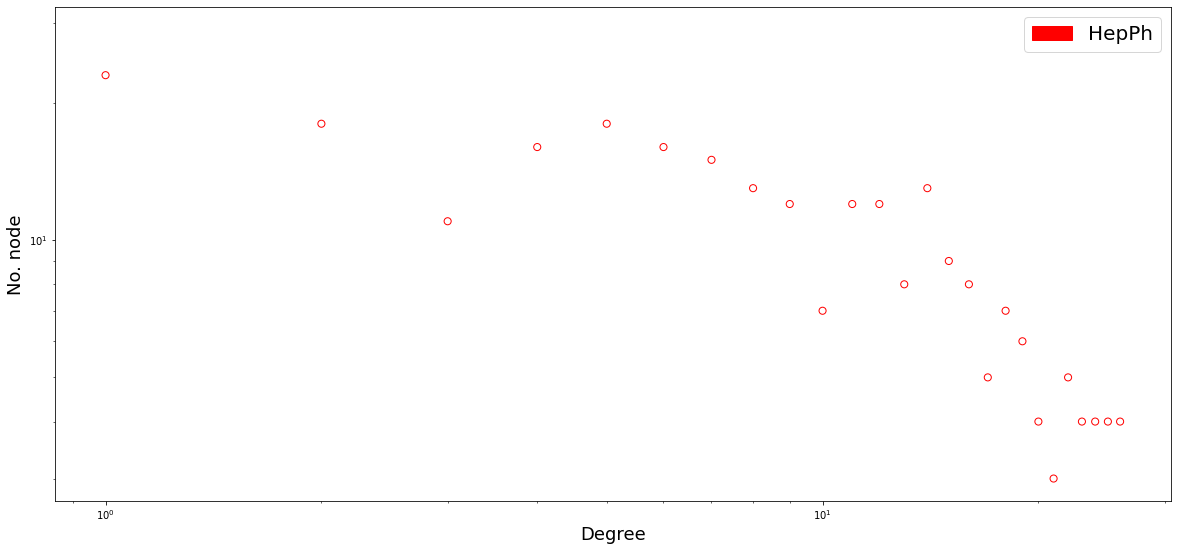

In [300]:
#Dataset descritpion
max_degree = max([e[1] for e in G.degree])
avg_degree = '{0:.3g}'.format(mean([e[1] for e in G.degree]))
avg_clustering_coefficient = '{0:.4g}'.format(nx.average_clustering(G))

dt_description = pd.DataFrame({
    "name":[dataset_name],
    "No. vertices":[G.number_of_nodes()],
    "No. edges":[G.number_of_edges()],
    "Max. deg":[max_degree],
    "Avg. deg":[avg_degree],
    "Avg. CC":[avg_clustering_coefficient]})
print(dt_description)

#Graph for show degree distribution of nodes
show_degree_distribution(G,dataset_name)

## Filtering Phase

In this phase firt we filter the graph, we start removing the whiskers which are nodes connected only with one bridge.

We repeat the operation until no more nodes have ony one connection, the resulted graph is called biconnected core.

The biconnected core is defined as the largest connected component of the graph after we remove all single-edge biconnected components (whiskers).

In [301]:
#Filtering phase
    #Filtering the graph, removing the  whiskers from the biconnected core
def filter_detached_graph(G,G_biconnected_core):
    for n in G_biconnected_core.nodes:
        G.remove_node(n)
    return G


G2 = G.copy()
G3 = filtered_graph(G2)



G_biconnected_core = G3.subgraph(max(nx.connected_components(G3), key=len)).copy()

# fig = plt.figure(1, figsize=(20, 20), dpi=80)
# nx.draw(G_biconnected_core , node_size=50,with_labels=True)
# plt.show()

G_detached = filter_detached_graph(G.copy(),G_biconnected_core)


# fig = plt.figure(1, figsize=(20, 20), dpi=80)
# nx.draw(G_detached , node_size=50,with_labels=True)
# plt.show()

print("G statistics before filtering:")
print("     -"+nx.info(G))
print("G_biconnected statistics after filtering:")
print("     -"+nx.info(G_biconnected_core))
print("")
perc_no_verticles = '{0:.3g}'.format(len(G_biconnected_core.nodes)/len(G.nodes)*100)
perc_no_edges = '{0:.3g}'.format(len(G_biconnected_core.edges)/len(G.edges)*100)
max_comp_detach =  len(max(nx.connected_components(G_detached), key=len))
perc_max_comp_detach ='{0:.3g}'.format(max_comp_detach / len(G.nodes) * 100) 

bc_description = pd.DataFrame({
    "No. of vertices (%)":[str(len(G_biconnected_core.nodes))+'('+str(perc_no_verticles)+')'],
    "No. of edges (%)":[str(len(G_biconnected_core.edges))+'('+str(perc_no_edges)+')'],
    "No. components detached":[len(G_detached.nodes)],
    "Size of the LCC (%)":[str(max_comp_detach)+"("+str(perc_max_comp_detach)+")"]})
print(bc_description)




G statistics before filtering:
     -Graph with 333 nodes and 2519 edges
G_biconnected statistics after filtering:
     -Graph with 299 nodes and 2489 edges

  No. of vertices (%) No. of edges (%)  No. components detached  \
0           299(89.8)       2489(98.8)                       34   

  Size of the LCC (%)  
0              6(1.8)  


## Seeding Phase

The goal of an effective seeding strategy is to identify a diversity of vertices, each of which lies

within a cluster of good conductance.

In [302]:
# def get_best_partition(G):
#     modularity_list = []
#     counter = 0
#     print("starting girvan newmann community detection")
#     communities = girvan_newman(G)
#     len_community = len(list(communities))
#     print("finiseh community detection")
#     for c in communities:
#         print("Elaborating "+str(counter) +" of "+str(len_community))
#         modularity_list.append(modularity(G,c))
#         counter += 1

#     plt.plot(np.arange(len(modularity_list)),modularity_list)
#     plt.xlabel("Community level")
#     plt.ylabel("Modularity")
#     plt.show()
#     return
# G_partitioned = get_best_partition(G_biconnected_core)

In [303]:
#Exhaustive non-overlapping clusters on G_biconnected_core
communities_subgraphs_clusters = get_subgraphs_cluster(G_biconnected_core)
#Get seed list computing the Graclus center algorithm
seed_dict_gc = compute_graclus_center(communities_subgraphs_clusters,G_biconnected_core)
#Get seed list computing the Spread Hubs

Number of communities with best modularity: 8


## Seed expansion phase

In [304]:

k = 8
Gb_copy = G_biconnected_core.copy()


    # print(filtered_nodes)
    # print(Gb_copy.degree(filtered_nodes))

77
25
24


In [307]:
print(seed_list)
print(seed_dict_gc)

[56, 62, 185, 312, 158, 232, 161, 297, 324]
{'C0': 56, 'C1': 213, 'C2': 312, 'C3': 31, 'C4': 339, 'C5': 150, 'C6': 4, 'C7': 89}
